In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import matplotlib
%matplotlib inline
import numpy as np
import pandas as pd

## CSVs

In [35]:
tracks_df = pd.read_csv('data/spotify_2017.csv', usecols=['name','artists'])
tracks_df.head()

,name,artists
0,Shape of You,Ed Sheeran
1,Despacito - Remix,Luis Fonsi
2,Despacito (Featuring Daddy Yankee),Luis Fonsi
3,Something Just Like This,The Chainsmokers
4,I'm the One,DJ Khaled


## APIs

In [36]:
from music import get_lyrics

In [7]:
artist = 'The Beatles'
title = 'Come '

x = get_lyrics(artist,title)

In [8]:
print(x)

In [11]:
tracks_df.head()

,name,artists
0,Shape of You,Ed Sheeran
1,Despacito - Remix,Luis Fonsi
2,Despacito (Featuring Daddy Yankee),Luis Fonsi
3,Something Just Like This,The Chainsmokers
4,I'm the One,DJ Khaled


In [12]:
tracks_df.shape

(100, 2)

In [26]:
tracks_df.head()

,name,artists
0,Shape of You,Ed Sheeran
1,Despacito - Remix,Luis Fonsi
2,Despacito (Featuring Daddy Yankee),Luis Fonsi
3,Something Just Like This,The Chainsmokers
4,I'm the One,DJ Khaled


In [30]:
tracks_df.set_index('name', inplace=True)
tracks_df.head()

,artists
name,
Shape of You,Ed Sheeran
Despacito - Remix,Luis Fonsi
Despacito (Featuring Daddy Yankee),Luis Fonsi
Something Just Like This,The Chainsmokers
I'm the One,DJ Khaled


In [34]:
tracks_df.iloc[:5,0 ]

name
Shape of You                                Ed Sheeran
Despacito - Remix                           Luis Fonsi
Despacito (Featuring Daddy Yankee)          Luis Fonsi
Something Just Like This              The Chainsmokers
I'm the One                                  DJ Khaled
Name: artists, dtype: object

In [37]:
tracks_df['lyrics'] = ''

for i, r in tracks_df.head(5).iterrows():
    print('Fetching lyrics for ', i)
    tracks_df.loc[i, 'lyrics'] = get_lyrics(r['artists'], r['name'])
    
    

Fetching lyrics for  0
Fetching lyrics for  1
Fetching lyrics for  2
Fetching lyrics for  3
Fetching lyrics for  4


In [38]:
tracks_df.head()

,name,artists,lyrics
0,Shape of You,Ed Sheeran,The club isn't the best place to find a lover\...
1,Despacito - Remix,Luis Fonsi,
2,Despacito (Featuring Daddy Yankee),Luis Fonsi,
3,Something Just Like This,The Chainsmokers,I've been reading books of old\nThe legends an...
4,I'm the One,DJ Khaled,[DJ Khaled:]\nWe The Best Music\nAnother One!\...


## SQL

In [39]:
import pandas as pd
import sqlite3
conn = sqlite3.connect("data/soccer.sqlite")

In [40]:
## OLD WAY
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
print(cursor.fetchall())

[('sqlite_sequence',), ('Player_Attributes',), ('Player',), ('Match',), ('League',), ('Country',), ('Team',), ('Team_Attributes',)]


In [41]:
## NEW WAY
league_df = pd.read_sql(
    '''
    SELECT l.id, l.name, c.name as country_name
    FROM League l
    JOIN Country c ON c.id = l.country_id
    ''', conn)

In [42]:
league_df.head()

,id,name,country_name
0,1,Belgium Jupiler League,Belgium
1,1729,England Premier League,England
2,4769,France Ligue 1,France
3,7809,Germany 1. Bundesliga,Germany
4,10257,Italy Serie A,Italy


## Google Big Query

In [43]:
import pandas_gbq


In [46]:
project_id = 'bootcamps-august' # TODO: replace with your own!

query = """
SELECT faa_identifier, name, longitude, latitude, airport_type, service_city, country
FROM `bigquery-public-data.faa.us_airports`
WHERE airport_use = 'Public'
"""
airports_df = pandas_gbq.read_gbq(query, project_id=project_id)
airports_df.head()

Downloading: 100%|██████████████████████| 5368/5368 [00:01<00:00, 5188.88rows/s]


,faa_identifier,name,longitude,latitude,airport_type,service_city,country
0,2A4,Vor Lake Waterlane,-151.494167,66.887445,Seaport,Bettles,United States
1,5C5,El Capitan Lodge,-133.253391,55.958593,Seaport,Craig,United States
2,3A3,Seymour Lake Spb,-149.665593,61.613463,Seaport,Wasilla,United States
3,T44,Trident Basin,-152.391410,57.780835,Seaport,Kodiak,United States
4,84K,Meyers Chuck,-132.255037,55.739641,Seaport,Meyers Chuck,United States


In [45]:
type(airports_df)

pandas.core.frame.DataFrame

## SCRAPING

In [47]:
import re
import requests
from bs4 import BeautifulSoup

In [50]:
url = 'https://www.imdb.com/list/ls055386972/'

response = requests.get(url)

soup = BeautifulSoup(response.content, 'html.parser')

In [68]:
movies = []
movies_raw = soup.find_all('div', class_='lister-item-content')

for movie in movies_raw:
    title = movie.find('h3', class_='lister-item-header').find('a').text
    runtime = int(movie.find('span', class_='runtime').text.strip(' min'))
    year = int(re.search('\d{4}', movie.find('span', class_='lister-item-year').text).group(0))
    movies.append({'title': title, 'runtime': runtime, 'year':year})

In [69]:
movies[0:3]

[{'title': 'The Godfather', 'runtime': 175, 'year': 1972},
 {'title': "Schindler's List", 'runtime': 195, 'year': 1993},
 {'title': '12 Angry Men', 'runtime': 96, 'year': 1957}]

In [70]:
movies_df = pd.DataFrame(movies)
movies_df.head()

,title,runtime,year
0,The Godfather,175,1972
1,Schindler's List,195,1993
2,12 Angry Men,96,1957
3,Life Is Beautiful,116,1997
4,"The Good, the Bad and the Ugly",148,1966


In [76]:
def scrape_page(page_num):
    url = 'https://www.imdb.com/search/title'
    params = {'groups':'top_250',
              'sort':'user_rating',
             'start': page_num}

    response = requests.get(url, params=params)

    soup = BeautifulSoup(response.content, 'html.parser')
    return soup


def parse_page(soup):
    movies = []
    movies_raw = soup.find_all('div', class_='lister-item-content')

    for movie in movies_raw:
        title = movie.find('h3', class_='lister-item-header').find('a').text
        runtime = int(movie.find('span', class_='runtime').text.strip(' min'))
        year = int(re.search('\d{4}', movie.find('span', class_='lister-item-year').text).group(0))
        movies.append({'title': title, 'runtime': runtime, 'year':year})
    return movies


In [78]:
all_movies = []
for i in range(5):
    page_num = i * 50 + 1
    soup = scrape_page(page_num)
    all_movies += parse_page(soup)
    

In [79]:
len(all_movies)

250

In [80]:
movies_df = pd.DataFrame(all_movies)
movies_df

,title,runtime,year
0,The Shawshank Redemption,142,1994
1,The Godfather,175,1972
2,The Dark Knight,152,2008
3,The Lord of the Rings: The Return of the King,201,2003
4,Schindler's List,195,1993
...,...,...,...
245,Mr. Smith Goes to Washington,129,1939
246,It Happened One Night,105,1934
247,The Incredibles,115,2004
248,Aladdin,90,1992


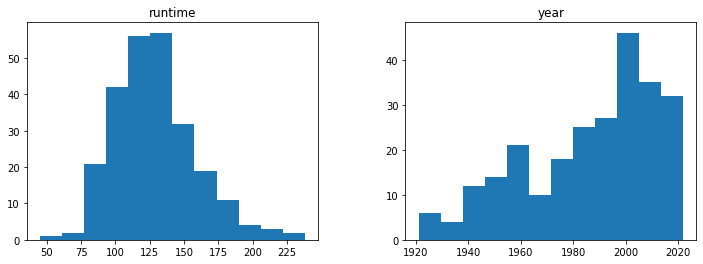

In [87]:
movies_df.hist(grid=False, bins=12, figsize=(12, 4));